# Figures

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt = plotter(backend='agg')
%matplotlib inline

In [5]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000
from pyproj import Proj
from matplotlib import cm

In [8]:
import location_tools

ModuleNotFoundError: No module named 'location_tools'

In [9]:
pixel = 15
cmap = cm.jet
extent = lambda s: [-pixel*s/2, pixel*s/2, -pixel*s/2, pixel*s/2]
decloud = lambda x, cut: np.choose(x<cut, [np.zeros_like(x), x])
amp = lambda x, alpha: 255*((x-np.min(x))/(np.max(x)-np.min(x)))**alpha

## CGS-02 and BD-09 Correction

In [ ]:
index = pd.read_csv('targets/google_scenes_2002_mincloud.csv')

In [ ]:
x_lon, x_lat = 116.390797, 39.916406 # beijing (forbidden city)

# scale params
vmin, vmax = 32, 100
rad, size = 256, 512
ext = extent(size)

# extract tiles
tile0 = location_tools.extract_satelite_tile(x_lon, x_lat, index, rad=rad, size=size, proj='bd-09')
tile1 = location_tools.extract_satelite_tile(x_lon, x_lat, index, rad=rad, size=size, proj='wgs-84')
arr0, arr1 = np.asarray(tile0), np.asarray(tile1)

# make plots
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].imshow(arr0, cmap=cm.jet, interpolation='lanczos', vmin=vmin, vmax=vmax, extent=ext)
ax[1].imshow(arr1, cmap=cm.jet, interpolation='lanczos', vmin=vmin, vmax=vmax, extent=ext)
ax[0].scatter([0], [0], c='r');
ax[1].scatter([0], [0], c='r');
ax[0].set_title('Uncorrected BG-09 Coordinates')
ax[1].set_title('Corrected WGS-84 Coordinates')
fig.savefig('draft/images/bd_wgs_compare.svg');

## Landsat Imagery Demo

In [ ]:
coldefs = {'No': 'id', 'longitude': 'lon', 'latitude': 'lat'}
firms = pd.read_csv('firms/census_2004_geocode.csv', usecols=coldefs).rename(columns=coldefs)

In [ ]:
fid = 1082781 # Shanghai Happy Vacuum Cleaner Factory
info = firms[firms['id']==fid].iloc[0]
x_lon, x_lat = info[['lon', 'lat']]

# scale params
rad0, rad1 = 256, 1024
vmin, vmax = 32, 130
ext0, ext1 = extent(rad0), extent(rad1)
size = 512

# extract tiles
tile0 = location_tools.extract_satelite_tile(x_lon, x_lat, index, rad=rad0, size=size, proj='bd-09')
tile1 = location_tools.extract_satelite_tile(x_lon, x_lat, index, rad=rad1, size=size, proj='bd-09')
arr0, arr1 = np.asarray(tile0), np.asarray(tile1)
arr0, arr1 = decloud(arr0, 100), decloud(arr1, 100)

# make plots
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].imshow(arr0, cmap=cmap, interpolation='lanczos', vmin=vmin, vmax=vmax, extent=ext0)
ax[1].imshow(arr1, cmap=cmap, interpolation='lanczos', vmin=vmin, vmax=vmax, extent=ext1)
ax[0].scatter([0], [0], c='r');
ax[1].scatter([0], [0], c='r');
ax[0].set_title('Firm Location, 2km Radius')
ax[1].set_title('Firm Location, 7km Radius')
fig.savefig('draft/images/landsat_demo.svg');

## Firm Density Demo

In [ ]:
# lon1, lat1 = 116.390797, 39.916406 # beijing
# lon1, lat1 = 114.066500, 22.654437 # huawei
# lon1, lat1 = 104.066465, 30.658427 # chengdu
lon0, lat0 = 121.439610, 31.265273 # shanghai
lon1, lat1 = 108.944372, 34.265481 # xi'an

rad0, rad1 = 1800, 512
ext0, ext1 = extent(rad0), extent(rad1)
vmin, vmax = 32, 130
size = 512

sat = location_tools.extract_satelite_tile(lon0, lat0, index, rad=rad0, size=size, proj='bd-09')
den = location_tools.extract_density_tile(lon0, lat0, rad=rad0, size=size, proj='bd-09')
arr_sat, arr_den = np.asarray(sat), np.asarray(den)
arr_sat, arr_den = 1.0*amp(decloud(arr_sat, 100), 2.5), amp(arr_den, 0.7)
arr_mix0 = np.stack([arr_sat/255+2*arr_den/255, arr_sat/255, arr_sat/255], axis=2)

sat = location_tools.extract_satelite_tile(lon1, lat1, index, rad=rad1, size=size, proj='bd-09')
den = location_tools.extract_density_tile(lon1, lat1, rad=rad1, size=size, proj='bd-09')
arr_sat, arr_den = np.asarray(sat), np.asarray(den)
arr_sat, arr_den = 1.4*amp(decloud(arr_sat, 100), 3.5), amp(arr_den, 0.7)
arr_mix1 = np.stack([arr_sat/255+2*arr_den/255, arr_sat/255, arr_sat/255], axis=2)

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].imshow(arr_mix0, interpolation='lanczos', extent=ext0)
ax[1].imshow(arr_mix1, interpolation='lanczos', extent=ext1)
ax[0].set_title('Shanghai, 13k Radius')
ax[1].set_title('Xi\'an, 4km Radius')
fig.savefig('draft/images/density_overlay.svg');

## Density Maps

In [15]:
def chunk_path(tag, loc='../tiles/density/1024px', ext='jpg'):
    tag = f'{tag:07d}'
    sub = tag[:4]
    psub = f'{loc}/{sub}'
    ptag = f'{psub}/{tag}.{ext}'
    return ptag

In [68]:
def add_border(x):
    x = x.copy()
    x[0,:] = 255
    x[-1,:] = 255
    x[:,0] = 255
    x[:,-1] = 255
    return x

In [69]:
ids = [425286, 425777, 425920, 425951]

In [70]:
paths = [chunk_path(i) for i in ids]
images = [np.asarray(Image.open(p)) for p in paths]
images = [255*(x>20).astype(np.uint8) for x in images]
images = [add_border(x) for x in images]

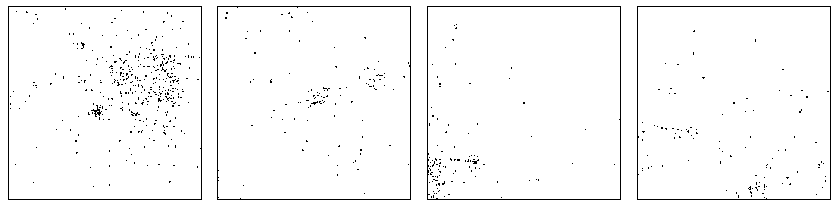

In [75]:
fig, axs = plt.subplots(ncols=len(ids), figsize=(12, 3))
for i, _ in enumerate(ids):
    ax = axs[i]
    ax.imshow(images[i], origin='lower', cmap='Greys')
    ax.set_xlim(-1, 256)
    ax.set_ylim(-1, 256)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
fig.savefig('../slides/images/density_example.png', dpi=300, bbox_inches='tight')